# Construction of eulerian comparison dataframe
- from L2 filtered data and field interpolation
- create a vaex.dataframe where each row is a point of comparison: 
['id',
 'time',
 'lat',
 'lon',
 'u_drifter',
 'v_drifter',
 'u_geo_swot',
 'v_geo_swot',
 'u_var_swot',
 'v_var_swot',
 'u_geo_nadir',
 'v_geo_nadir',
 'u_var_nadir',
 'v_var_nadir']

#### Imports

In [22]:
import sys
import os
from glob import glob

import cartopy.geodesic as geod
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic

import scipy
import scipy.signal

import numpy as np
import xarray as xr
import vaex
import pandas as pd

import jax
import jax.numpy as jnp
import jaxparrow as jpw

import clouddrift as cd

sys.path.append(os.path.abspath(os.path.join('..', 'common_utils')))
from utils import *
from filters import *


%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt


drifters_directory = '/home/bouxdecl/Documents/data/DRIFTERS'
path_fields = '/home/bouxdecl/Documents/MEOM_internship_2024/save_data/fields_data'

path_save_data = '/home/bouxdecl/Documents/MEOM_internship_2024/save_data/eulerian_dataframes'
path_save_plot = '/home/bouxdecl/Documents/MEOM_internship_2024/save_plots/save_plots_2024-06-27_Generate_eulerian_points_dataframe_L3'

## Data and utils

#### field data

In [2]:
# L3 field data
ds_swot = xr.open_dataset(os.path.join(path_fields, 'field_L3SWOT.nc'))

ds_swot  = add_Tgrid_velocities(ds_swot,  replace=True)
ds_swot

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


<xarray.Dataset>
Dimensions:    (time: 90, y: 399, x: 69)
Coordinates:
  * time       (time) datetime64[ns] 2023-03-30T00:12:09 ... 2023-07-09T08:16:31
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables:
    ssh        (time, y, x) float32 ...
    u_geos     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    v_geos     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    u_var      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    v_var      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    DATAPRODUCT:   L3SWOT_20240626
    gridtype_adt:  T grid : (latitude, longitude)
    gridtype_uv:   U/V grid

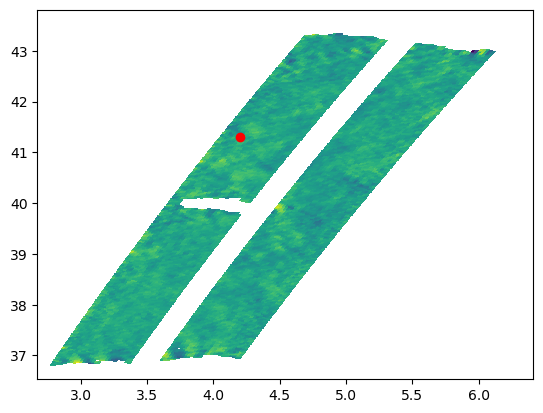

In [4]:
plt.pcolormesh(ds_swot.longitude, ds_swot.latitude, ds_swot.v_geos[0])
plt.scatter(4.2, 41.3, c='r')

(38.0, 39.0)

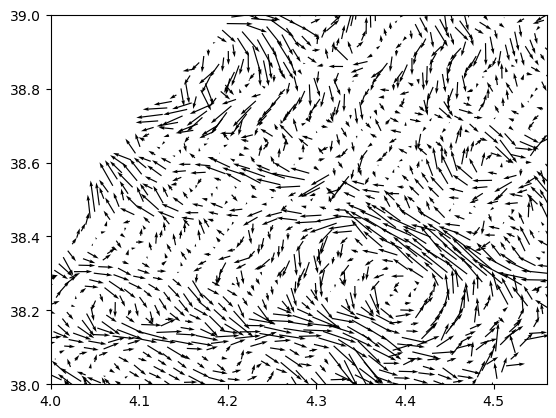

In [10]:
plt.quiver(ds_swot.longitude, ds_swot.latitude, ds_swot.u_geos[0], ds_swot.v_geos[0], scale=8)
plt.xlim(4, 4.56)
plt.ylim(38, 39)

In [13]:
0.1*np.sin(38.2/180*np.pi)*6400*2*np.pi/360

6.907688077417048

In [15]:
cd.sphere.distance(4, 38.2, 4.1, 38.2)

8748.067745417142

#### interpolate

In [3]:

def interp_closest_velocity_field_L3(ds, u: str, v: str, time_vec, lat_vec, lon_vec):

    #find the closest x,y coords of the interpolation points 
    x_vec = np.empty_like(lon_vec)
    y_vec = np.empty_like(lat_vec)

    for i, (lon, lat) in enumerate(zip(lon_vec, lat_vec)):
        abslat = np.abs(ds.latitude-lat)
        abslon = np.abs(ds.longitude-lon)
        c = np.maximum(abslon, abslat)

        min_idx = np.where(c == np.min(c))
        y_vec[i], x_vec[i] = min_idx[0][0], min_idx[1][0]

    #create indexers DataArrays 
    x_idx = xr.DataArray(x_vec)
    y_idx = xr.DataArray(y_vec)
    time_idx = xr.DataArray(time_vec)

    #xarray interpolate
    interped = ds.interp(x=x_idx, y=y_idx, time=time_idx)

    return interped[u].values, interped[v].values



def interp_velocity_field_L3(field, u: str, v: str, time_vec, lat_vec, lon_vec):
    
    ds = field.interp(time=time_vec)
    if len(time_vec) == 1:
        u_interp = scipy.interpolate.griddata((ds.latitude.values.flatten(), ds.longitude.values.flatten()), ds[u].values.flatten(), (lat_vec, lon_vec))
        v_interp = scipy.interpolate.griddata((ds.latitude.values.flatten(), ds.longitude.values.flatten()), ds[v].values.flatten(), (lat_vec, lon_vec))
        return u_interp, v_interp
    else:    
        u_interp = np.empty_like(lat_vec)
        v_interp = np.empty_like(lat_vec)
        for i in range(len(time_vec)):
            di = ds.isel(time=i)
            u_interp[i] = scipy.interpolate.griddata((di.latitude.values.flatten(), di.longitude.values.flatten()), di[u].values.flatten(), (lat_vec[i], lon_vec[i])) 
            v_interp[i] = scipy.interpolate.griddata((di.latitude.values.flatten(), di.longitude.values.flatten()), di[v].values.flatten(), (lat_vec[i], lon_vec[i])) 
        return u_interp, v_interp
        

print(interp_closest_velocity_field_L3(ds_swot, u='u_geos', v='v_geos', time_vec=np.array(['2023-04-09T19:30:00.000000000'], dtype='datetime64[ns]'), lat_vec=[41.2], lon_vec=[4.2]) )
print(interp_velocity_field_L3(ds_swot, u='u_geos', v='v_geos', time_vec=np.array(['2023-04-09T19:30:00.000000000'], dtype='datetime64[ns]'), lat_vec=[41.2], lon_vec=[4.2]) )

(array([-0.08440927]), array([0.25734516]))
(array([-0.10790217]), array([0.26218593]))


In [4]:
interp_closest_velocity_field_L3(ds_swot, u='u_geos', v='v_geos', time_vec=np.array(['2023-04-09T19:30', '2023-04-20T19:30:45'], dtype='datetime64[ns]'), lat_vec=[41.3, 41.3], lon_vec=[4.2, 4.2])

(array([-0.05126897,  0.01864474]), array([ 0.31123943, -0.10489941]))

In [5]:
interp_velocity_field_L3(ds_swot, u='u_geos', v='v_geos', time_vec=np.array(['2023-04-09T19:30', '2023-04-20T19:30:45'], dtype='datetime64[ns]'), lat_vec=[41.3, 41.3], lon_vec=[4.2, 4.2])

(array([-0.07280664, -0.03209046]), array([ 0.31330818, -0.06411492]))

In [6]:
interp_exactclosest_velocity_field_L3(ds_swot, u='u_geos', v='v_geos', time_vec=np.array(['2023-04-09T19:30', '2023-04-20T19:30:45'], dtype='datetime64[ns]'), lat_vec=[41.3, 41.3], lon_vec=[4.2, 4.2])

NameError: name 'interp_exactclosest_velocity_field_L3' is not defined

#### essais interp

In [152]:
def get_1time2dinterp_velocities(dslat, dslon, dsu, dsv, lat_vec, lon_vec):
    u_interp = scipy.interpolate.griddata((dslat.flatten(), dslon.flatten()), dsu.flatten(), (lat_vec, lon_vec))
    v_interp = scipy.interpolate.griddata((dslat.flatten(), dslon.flatten()), dsv.flatten(), (lat_vec, lon_vec))
    return u_interp, v_interp


jnp.vectorize(get_1time2dinterp_velocities)

<function __main__.get_1time2dinterp_velocities(dslat, dslon, dsu, dsv, lat_vec, lon_vec)>

In [175]:
ds = ds_swot.interp(time=np.array(['2023-04-09T19:30', '2023-04-20T19:30:45'], dtype='datetime64[ns]'))

dslat = jnp.copy(ds.latitude.values)
dslon = jnp.copy(ds.longitude.values)
dsu = jnp.copy(ds.u_geos.values)
dsv = jnp.copy(ds.v_geos.values)

lat_vec= jnp.array([41.3, 41.3])
lon_vec= jnp.array([4.2, 4.2] )

def get_1time2dinterp_velocities(dsu, dsv):
    u_interp = scipy.interpolate.griddata((dslat.flatten(), dslon.flatten()), dsu.flatten(), (lat_vec, lon_vec))
    v_interp = scipy.interpolate.griddata((dslat.flatten(), dslon.flatten()), dsv.flatten(), (lat_vec, lon_vec))
    return u_interp, v_interp

vget = jax.vmap(get_1time2dinterp_velocities, in_axes=(0, 0))

In [ ]:




ds = ds_swot.interp(time=np.array(['2023-04-09T19:30', '2023-04-20T19:30:45'], dtype='datetime64[ns]'))


def get_1time2dinterp_velocities(dslat, dslon, dsu, dsv, lat_vec, lon_vec):
    u_interp = scipy.interpolate.griddata((dslat.flatten(), dslon.flatten()), dsu.flatten(), (lat_vec, lon_vec))
    v_interp = scipy.interpolate.griddata((dslat.flatten(), dslon.flatten()), dsv.flatten(), (lat_vec, lon_vec))
    return u_interp, v_interp


u='u_geos' 
v='v_geos'
def interpolate_all_times(ds, lat_vec, lon_vec):

    result = xr.apply_ufunc(
        get_1time2dinterp_velocities,
        ds.latitude, ds.longitude, ds[v], ds[u], lat_vec, lon_vec,
        input_core_dims=[['x', 'y'], ['x', 'y'], ['x', 'y'], ['x', 'y'], [], []],
        #output_core_dims=[['x', 'y']],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float]
    )
    return result

# Apply the function
result = interpolate_all_times(ds, lat_vec, lon_vec)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (2,) and arg 4 with shape (10,).

In [110]:
""" import numpy as np
import xarray as xr
import pandas as pd

# Example xarray dataset
ds = xr.Dataset({
    'u': (['time', 'latitude', 'longitude'], np.random.rand(10, 5, 5)),
    'latitude': (['latitude'], np.linspace(0, 4, 5)),
    'longitude': (['longitude'], np.linspace(0, 4, 5)),
    'time': (['time'], pd.date_range('2021-01-01', periods=10))
})

# Define a custom function to apply
def custom_function(value):
    return value ** 2 + 1

# Use apply_ufunc to apply the function across the 'time' dimension
result = xr.apply_ufunc(
    custom_function,  # function to apply
    ds['u'],          # input data
    vectorize=True,   # allows the function to work element-wise
    dask="parallelized",  # enables parallel computation with dask if available
    output_dtypes=[float]  # specify the output data type
)

result
 """

<xarray.DataArray 'u' (time: 10, latitude: 5, longitude: 5)>
array([[[1.34262453, 1.61157845, 1.32295362, 1.29313102, 1.98717591],
        [1.48213985, 1.33827741, 1.06658887, 1.51494834, 1.01625866],
        [1.26630859, 1.41588093, 1.4426432 , 1.731068  , 1.84228439],
        [1.18318662, 1.48224898, 1.03146435, 1.26339356, 1.58140526],
        [1.00174964, 1.24047446, 1.34715998, 1.66154173, 1.6375438 ]],

       [[1.66091095, 1.74891182, 1.02639403, 1.394561  , 1.18633582],
        [1.05505052, 1.20441105, 1.01869797, 1.26068133, 1.12038111],
        [1.347591  , 1.63623703, 1.20136567, 1.95012725, 1.09262818],
        [1.56324664, 1.33310922, 1.15848542, 1.36409688, 1.00000001],
        [1.00119769, 1.97231546, 1.39733949, 1.27785122, 1.68834073]],

       [[1.22217822, 1.01612942, 1.77990734, 1.00882904, 1.00197837],
        [1.00000014, 1.33579642, 1.87193255, 1.12744984, 1.13028615],
        [1.0191029 , 1.09383096, 1.76603948, 1.19669695, 1.05151174],
        [1.88942083, 1.0182394 , 1.56389485, 1.24843186, 1.01262713],
        [1.61140798, 1.13779691, 1.26905287, 1.04224434, 1.03653142]],

       [[1.46754356, 1.03495965, 1.14830759, 1.33743626, 1.10330299],
        [1.09008866, 1.09226684, 1.13529112, 1.00923183, 1.11431586],
...
        [1.03621191, 1.05494033, 1.25972287, 1.80597057, 1.16158241],
        [1.08348744, 1.83398624, 1.04583991, 1.62575337, 1.89000247]],

       [[1.27523351, 1.04539113, 1.90545431, 1.11370037, 1.00461999],
        [1.36993451, 1.19011561, 1.08134551, 1.01291239, 1.03724294],
        [1.04666032, 1.0113622 , 1.9643539 , 1.02116808, 1.190297  ],
        [1.25742563, 1.01379287, 1.13511668, 1.40811573, 1.000873  ],
        [1.05756495, 1.10440093, 1.05611053, 1.67098662, 1.14978266]],

       [[1.71339999, 1.20167212, 1.8624575 , 1.0102237 , 1.07794791],
        [1.74202451, 1.03946448, 1.20692667, 1.89340625, 1.02619473],
        [1.09219579, 1.54187146, 1.00440456, 1.33052551, 1.03597703],
        [1.05394569, 1.54711621, 1.74959036, 1.03351621, 1.52820885],
        [1.14777486, 1.00342883, 1.1068368 , 1.05246694, 1.00281419]],

       [[1.51601028, 1.41369796, 1.59174931, 1.0239883 , 1.9260852 ],
        [1.52063975, 1.23534593, 1.04510206, 1.04068726, 1.90303417],
        [1.00336371, 1.17146695, 1.49935091, 1.08306913, 1.54834975],
        [1.0953767 , 1.03993766, 1.64499333, 1.0087006 , 1.04337733],
        [1.50076411, 1.99865923, 1.98150124, 1.26622783, 1.56140531]]])
Coordinates:
  * latitude   (latitude) float64 0.0 1.0 2.0 3.0 4.0
  * longitude  (longitude) float64 0.0 1.0 2.0 3.0 4.0
  * time       (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-01-10

#### drifters data

filename convention : L1_type_source_aaaammjj_hhmmss_sampling.format

In [16]:
L2_dir = drifters_directory + '/L2'

mediterranea_files = file_selection_mediterranean(os.listdir(L2_dir))

file_lowess_10min = file_selection_by_method(mediterranea_files, "lowess")
file_lowess_10min = file_selection_by_sampling(file_lowess_10min, "10min")

file_lowess_30min = file_selection_by_method(mediterranea_files, "lowess")
file_lowess_30min = file_selection_by_sampling(file_lowess_30min, "30min")

file_lowess_1h = file_selection_by_method(mediterranea_files, "lowess")
file_lowess_1h = file_selection_by_sampling(file_lowess_1h, "1h")

file_svp30min = file_selection_by_method(file_lowess_30min, "svp")

## One trajectory processing
- filter the drifters data from one trajectory
- interpolate the fields data at the filtered positions and times
- return a vaex dataframe with all the information for one point of eulerian comparison

#### func

In [8]:
def init_points_compa():
    return vaex.from_arrays(id   = np.empty(0, dtype= str),
                            time = np.empty(0, dtype=np.datetime64),
                            
                            lat = np.empty(0, dtype=np.float64),
                            lon = np.empty(0, dtype=np.float64),

                            u_drifter = np.empty(0, dtype=np.float64),
                            v_drifter = np.empty(0, dtype=np.float64),

                            u_geo_swot = np.empty(0, dtype=np.float64),
                            v_geo_swot = np.empty(0, dtype=np.float64),

                            u_var_swot = np.empty(0, dtype=np.float64),
                            v_var_swot = np.empty(0, dtype=np.float64),

                            u_geo_nadir = np.empty(0, dtype=np.float64),
                            v_geo_nadir = np.empty(0, dtype=np.float64),

                            u_var_nadir = np.empty(0, dtype=np.float64),
                            v_var_nadir = np.empty(0, dtype=np.float64)

                            )



def process_comparison_one_trajectory(traj: xr.Dataset, vector_spacing: int, interp_func, filter_lonlat = 'gaussian'):
    '''
    traj: xr.Dataset, 
    trajectory with vars: time, lat, lon, u, v
    
    vector_spacing: int
    spacing between points that are saved

    RETURN: points: vaex.dataframe with index : # id	time	lat	lon	u_drifter	v_drifter	u_geo_swot	v_geo_swot	u_var_swot	v_var_swot	u_geo_nadir	v_geo_nadir	u_var_nadir	v_var_nadir
    '''

    time, lat, lon, u, v = traj.time.values, traj.lat.values, traj.lon.values, traj.u.values, traj.v.values  
    dt = float(traj.time[1] - traj.time[0])*1e-9

    # --- Velocities filtering
    U = u + 1j* v
    U_filtered = low_pass_complex(U, dt=dt)
    
    # take one value each vectorspacing
    time = time[::vector_spacing]
    
    U_filtered = U_filtered[::vector_spacing] 
    u_filtered = U_filtered.real
    v_filtered = U_filtered.imag


    # --- Position filtering
    if filter_lonlat == 'low_pass':
        X = lon + 1j* lat
        X_filtered = low_pass_complex(X, dt=dt)
        X_filtered = X_filtered[::vector_spacing] 

        lon_filtered = X_filtered.real
        lat_filtered = X_filtered.imag
        
    if filter_lonlat == 'gaussian':
        lon_filtered = gaussian_filter(lon, dt=dt)
        lat_filtered = gaussian_filter(lat, dt=dt)

        lon_filtered = lon_filtered[::vector_spacing]
        lat_filtered = lat_filtered[::vector_spacing]


    # --- get field interpolated velocities

    u_geo_swot, v_geo_swot = interp_func(ds_swot, 'u_geos', 'v_geos', time, lat_filtered, lon_filtered)
    u_var_swot, v_var_swot = interp_func(ds_swot, 'u_var',  'v_var',  time, lat_filtered, lon_filtered)


    # --- save in the vaex dataframe
    id_array = np.array( [id]*len(time) )
    
    points = vaex.from_arrays(id=id_array, time=time, 
                                lat=lat_filtered, lon=lon_filtered,

                                u_drifter=u_filtered, v_drifter=v_filtered,  

                                u_geo_swot=u_geo_swot, v_geo_swot=v_geo_swot,  
                                u_var_swot=u_var_swot, v_var_swot=v_var_swot,  
                            )
    
    return points

#### One trajectory test and multiple traj visualization

In [13]:
file_lowess_30min

['L2_svp_scripps_10min_lowess_30min_v0.nc',
 'L2_svp_ogs_1h_lowess_30min_v0.nc',
 'L2_carthe_lops_5min_lowess_30min_v0.nc',
 'L2_svp_ogs_10min_lowess_30min_v0.nc',
 'L2_spotter_lops_30min_lowess_30min_v0.nc',
 'L2_svp_shom_10min_lowess_30min_v0.nc',
 'L2_melodi_eodyn_10min_lowess_30min_v0.nc',
 'L2_svp_scripps_1h_lowess_30min_v0.nc',
 'L2_svp_bcg_10min_lowess_30min_v0.nc',
 'L2_code_ogs_10min_lowess_30min_v0.nc',
 'L2_carthe_cnr_5min_lowess_30min_v0.nc']

In [17]:
one_trajectory = xr.open_dataset(os.path.join(L2_dir, file_svp30min[2])).isel(id=18).dropna(dim='time', how='any', subset=['u'])
one_trajectory = one_trajectory.where(isnear_swath(one_trajectory.lon, one_trajectory.lat, dlon=0.5), drop=True)

points = process_comparison_one_trajectory(one_trajectory, vector_spacing=30, interp_func=interp_closest_velocity_field_L3, filter_lonlat='gaussian')

IndexError: index 18 is out of bounds for axis 0 with size 10

/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contourf(*args, **kwargs)


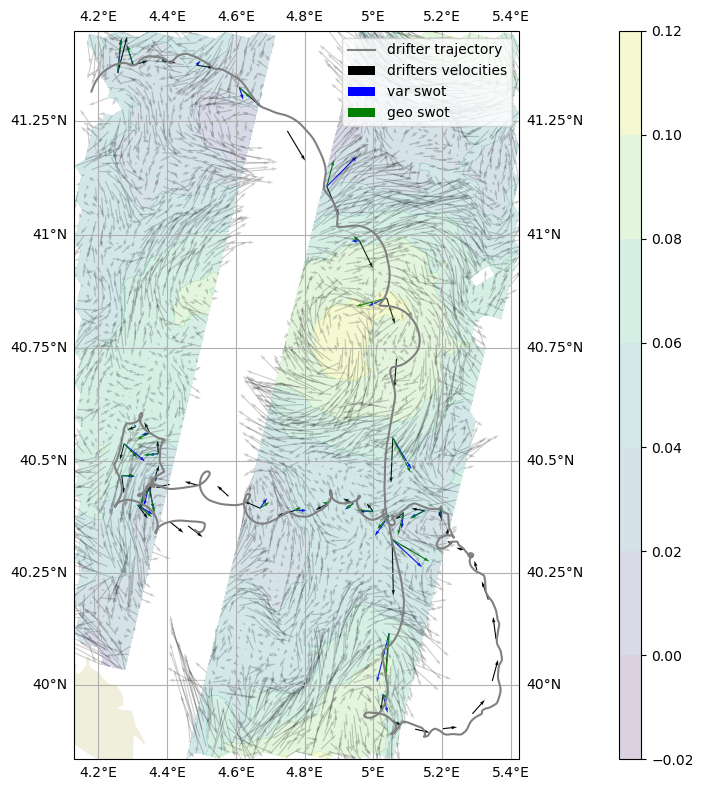

In [22]:

# Plot the trajectory with the velocity vectors AND fields vectors

fig = plt.figure(tight_layout=True, figsize=(8, 8))
crs = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
gl = ax.gridlines(draw_labels=True,)
ax.add_feature(cfeature.LAND,)
scale=1.5e-5 *2
width=2.5e-3

padd = 0.05
bbox = (np.nanmin(one_trajectory.lon.values) -padd, np.nanmax(one_trajectory.lon.values) +padd, np.nanmin(one_trajectory.lat.values)-padd, np.nanmax(one_trajectory.lat.values)+padd ) 

ax.set_extent(bbox, crs=crs)

# trajectory
ax.plot(one_trajectory.lon, one_trajectory.lat,transform=crs, color='grey', label='drifter trajectory')

# drifters velocity
ax.quiver(points['lon'].values, points['lat'].values, points['u_drifter'].values, points['v_drifter'].values, 
            color='black', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), label = 'drifters velocities')

# field velocity
ax.quiver(points['lon'].values, points['lat'].values, points['u_var_swot'].values, points['v_var_swot'].values, color='b', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), label='var swot')
ax.quiver(points['lon'].values, points['lat'].values, points['u_geo_swot'].values, points['v_geo_swot'].values, color='g', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), label='geo swot')


# ssh field
#time_ssh = get_mean_datetime(one_trajectory.time.values)
#time_ssh = np.nanmin(points['time'].values[0])
time_ssh = points['time'].values[25]

field = restrain_domain(ds_swot, *bbox)
field = field.interp(time=time_ssh)
ssh_field = ax.contourf(field.longitude, field.latitude, field.ssh, transform=crs, alpha=0.2, label='SSH (swot)')


# Add colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=1, axes_class=plt.Axes)
cbar = plt.colorbar(ssh_field, cax=cax)

# add velocity field

#ax.quiver(field.longitude.values, field.latitude.values, field.u_geos.values, field.v_geos.values, angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), alpha=0.2)
ax.quiver(field.longitude.values, field.latitude.values, field.u_var.values, field.v_var.values, angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), alpha=0.2)


ax.legend()
plt.savefig(os.path.join(path_save_plot, 'filtreddrifter_field_comparison.png'), bbox_inches='tight', dpi = 300)

##### See multiple trajectories

In [18]:
file_svp30min

['L2_svp_scripps_10min_lowess_30min_v0.nc',
 'L2_svp_ogs_1h_lowess_30min_v0.nc',
 'L2_svp_ogs_10min_lowess_30min_v0.nc',
 'L2_svp_shom_10min_lowess_30min_v0.nc',
 'L2_svp_scripps_1h_lowess_30min_v0.nc',
 'L2_svp_bcg_10min_lowess_30min_v0.nc']

/tmp/ipykernel_3496/1690803306.py:54: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  field = field.interp(time=time_ssh)
/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contourf(*args, **kwargs)
/tmp/ipykernel_3496/1690803306.py:54: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support 

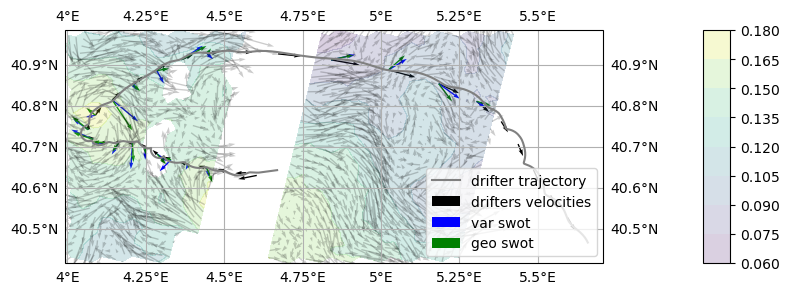

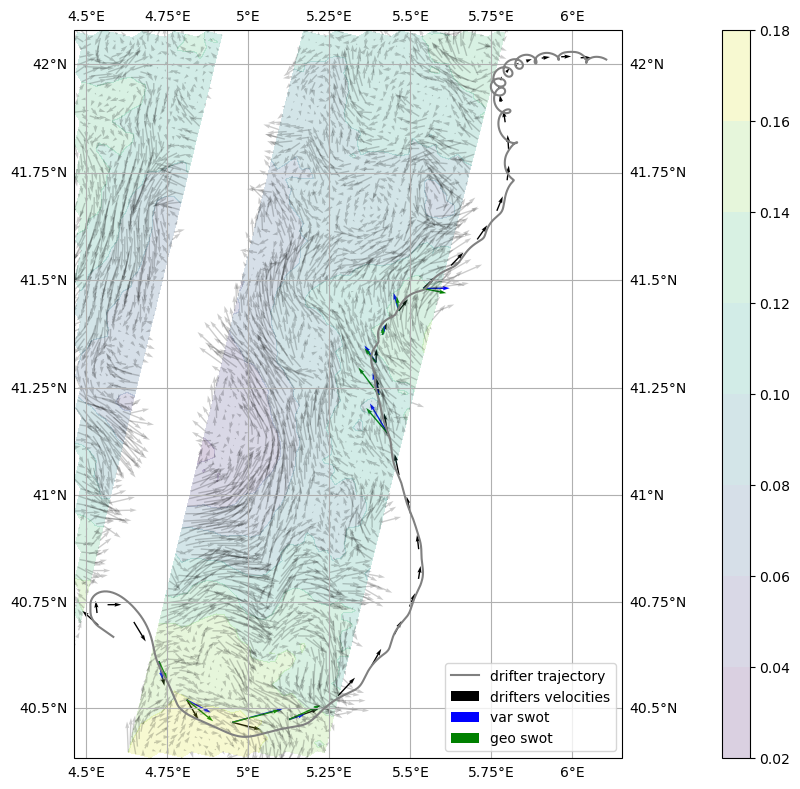

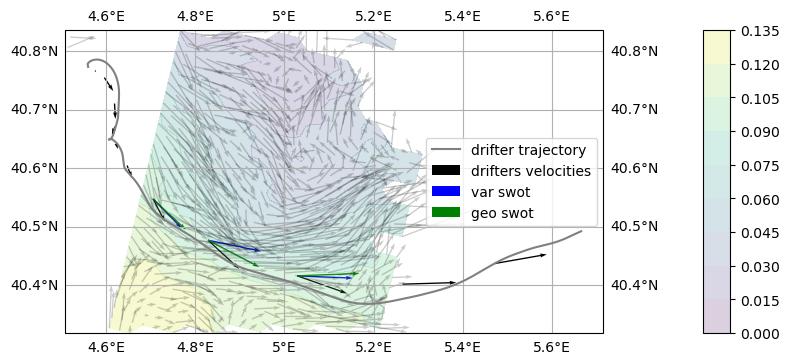

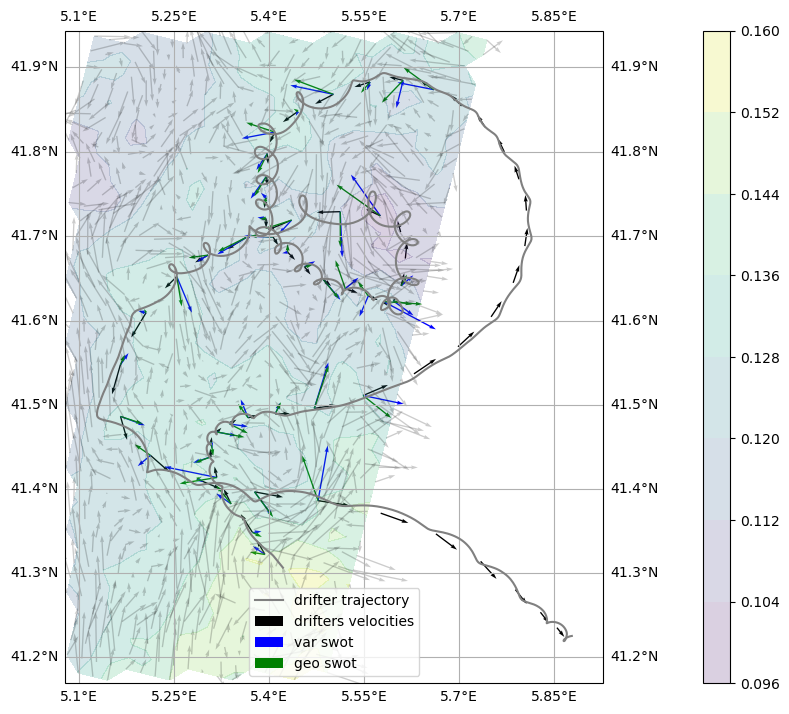

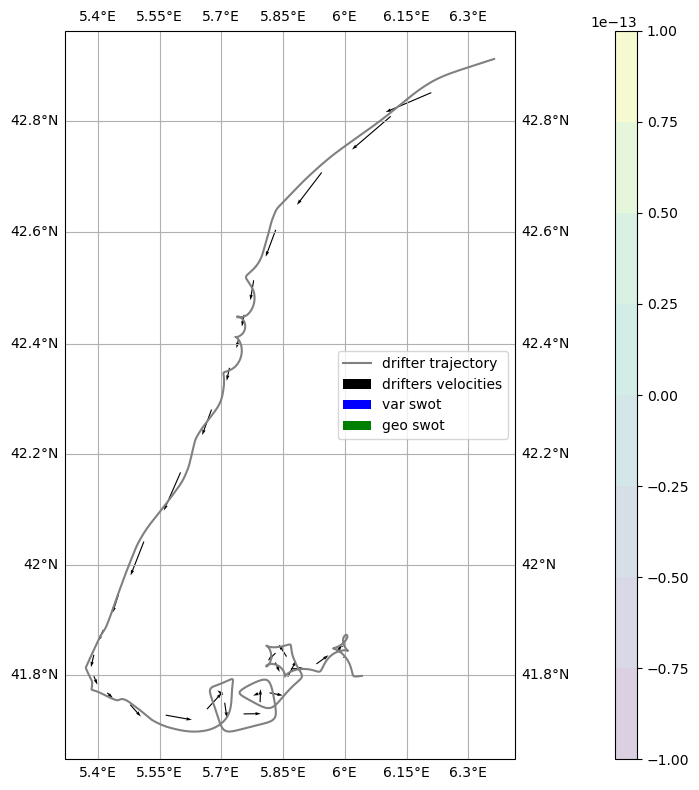

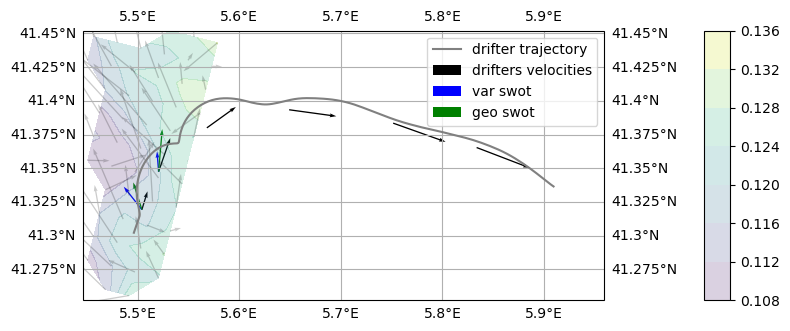

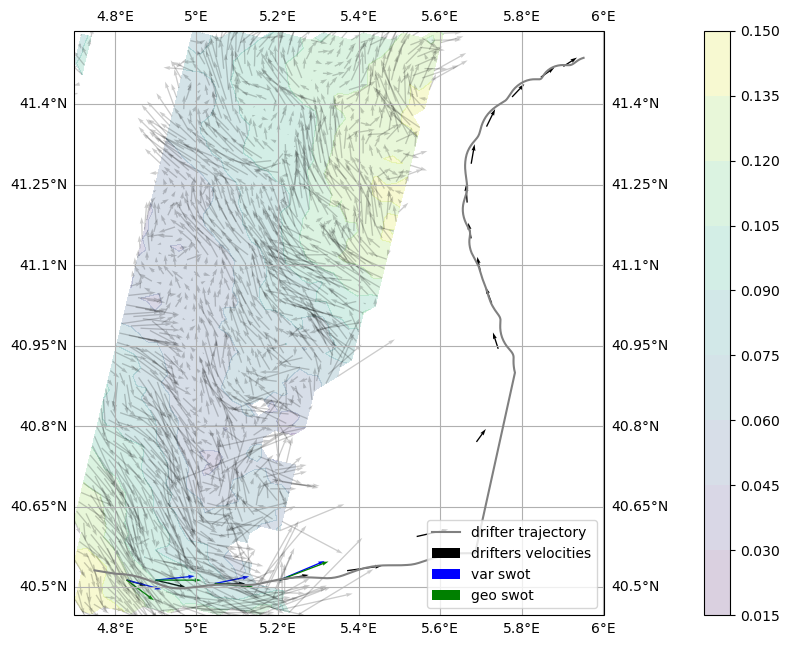

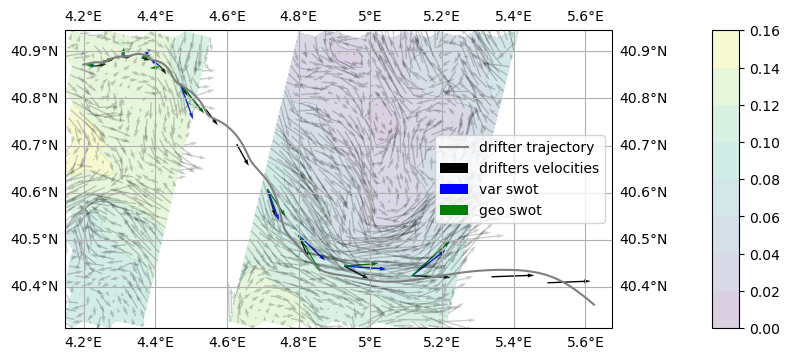

In [30]:
files = file_svp30min
sample = '30min'
file_n = 4

ds = xr.open_dataset(os.path.join(L2_dir, files[file_n]))

for id in range(len(ds.id.values)):
    one_trajectory = ds.isel(id=id).dropna(dim='time', how='any', subset=['u'])

    in_swath_idx = isnear_swath(one_trajectory.lon.values, one_trajectory.lat.values, dlon=0.5)
    span_drifters_days = float(np.nanmax(one_trajectory.time) - np.nanmin(one_trajectory.time))/1e9/(24*3600)

    if np.all(~in_swath_idx) or span_drifters_days < 4: # remove too small trajectories
        print('the trajectory is too small or not near the swath')

    else:
        one_trajectory = one_trajectory.where(isnear_swath(one_trajectory.lon, one_trajectory.lat, dlon=0.5), drop=True)

        points = process_comparison_one_trajectory(one_trajectory, vector_spacing=30, interp_func=interp_closest_velocity_field_L3, filter_lonlat='gaussian')
        
        # Plot the trajectory with the velocity vectors AND fields vectors

        fig = plt.figure(tight_layout=True, figsize=(8, 8))
        crs = ccrs.PlateCarree()
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
        gl = ax.gridlines(draw_labels=True,)
        ax.add_feature(cfeature.LAND,)
        scale=1.5e-5 *2
        width=2.5e-3

        padd = 0.05
        bbox = (np.nanmin(one_trajectory.lon.values) -padd, np.nanmax(one_trajectory.lon.values) +padd, np.nanmin(one_trajectory.lat.values)-padd, np.nanmax(one_trajectory.lat.values)+padd ) 

        ax.set_extent(bbox, crs=crs)

        # trajectory
        ax.plot(one_trajectory.lon, one_trajectory.lat,transform=crs, color='grey', label='drifter trajectory')

        # drifters velocity
        ax.quiver(points['lon'].values, points['lat'].values, points['u_drifter'].values, points['v_drifter'].values, 
                    color='black', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), label = 'drifters velocities')

        # field velocity
        ax.quiver(points['lon'].values, points['lat'].values, points['u_var_swot'].values, points['v_var_swot'].values, color='b', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), label='var swot')
        ax.quiver(points['lon'].values, points['lat'].values, points['u_geo_swot'].values, points['v_geo_swot'].values, color='g', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), label='geo swot')


        # ssh field
        time_ssh = get_mean_datetime(one_trajectory.time.values)
        #time_ssh = np.nanmin(points['time'].values[0])
        #time_ssh = points['time'].values[25]

        field = restrain_domain(ds_swot, *bbox)
        field = field.interp(time=time_ssh)
        ssh_field = ax.contourf(field.longitude, field.latitude, field.ssh, transform=crs, alpha=0.2, label='SSH (swot)')


        # Add colorbar
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=1, axes_class=plt.Axes)
        cbar = plt.colorbar(ssh_field, cax=cax)

        # add velocity field

        #ax.quiver(field.longitude.values, field.latitude.values, field.u_geos.values, field.v_geos.values, angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), alpha=0.2)
        ax.quiver(field.longitude.values, field.latitude.values, field.u_var.values, field.v_var.values, angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), alpha=0.2)


        ax.legend()
        plt.savefig(os.path.join(path_save_plot, 'filtreddrifter_field_comparison_file_lowess_{}_SVP_file {} and id {}.png'.format(sample, file_n, id)), bbox_inches='tight', dpi = 300)

## Create dataframe for several files

In [14]:

### CONVERT A FOLDER OF FILES INTO ONE POINTS COMPARISON DATAFRAME

files     = file_svp30min #file_lowess_30min
save_name = 'L3_test_lowess_30min_vs4_SVPonly'

vector_spacing = 4

# add points for each processed trajectory
points_compa = init_points_compa()
for file_number, file in enumerate(files):
    
    ds = xr.open_dataset(os.path.join(L2_dir, file))

    for i, id in enumerate(ds.id.values):
        print('processing file {} / {} ; id {} / {}'.format(file_number, len(file_lowess_1h)-1, i, ds.sizes['id']-1))
        
        traj = ds.sel(id=id).dropna(dim='time', how='any', subset=['u'])

        in_swath_idx = isnear_swath(traj.lon.values, traj.lat.values, dlon=0.5)
        span_drifters_days = float(np.nanmax(traj.time) - np.nanmin(traj.time))/1e9/(24*3600)

        if np.all(~in_swath_idx) or span_drifters_days < 4: # remove too small trajectories
            print('the trajectory is too small or not near the swath')

        else:
            traj = traj.where(isnear_swath(traj.lon, traj.lat, dlon=0.5), drop=True)
            points = process_comparison_one_trajectory(traj, vector_spacing, interp_func=interp_closest_velocity_field_L3, filter_lonlat = 'gaussian')
            points_compa = vaex.concat([points_compa, points])

# export to hdf5
points_compa.export_hdf5(os.path.join(path_save_data, save_name+'.hdf5'))

processing file 0 / 10 ; id 0 / 7
processing file 0 / 10 ; id 1 / 7
processing file 0 / 10 ; id 2 / 7
processing file 0 / 10 ; id 3 / 7
processing file 0 / 10 ; id 4 / 7
processing file 0 / 10 ; id 5 / 7
processing file 0 / 10 ; id 6 / 7
processing file 0 / 10 ; id 7 / 7
processing file 1 / 10 ; id 0 / 9
processing file 1 / 10 ; id 1 / 9
processing file 1 / 10 ; id 2 / 9
processing file 1 / 10 ; id 3 / 9
the trajectory is too small or not near the swath
processing file 1 / 10 ; id 4 / 9
processing file 1 / 10 ; id 5 / 9
the trajectory is too small or not near the swath
processing file 1 / 10 ; id 6 / 9
the trajectory is too small or not near the swath
processing file 1 / 10 ; id 7 / 9
the trajectory is too small or not near the swath
processing file 1 / 10 ; id 8 / 9
processing file 1 / 10 ; id 9 / 9
the trajectory is too small or not near the swath
processing file 2 / 10 ; id 0 / 9
processing file 2 / 10 ; id 1 / 9
processing file 2 / 10 ; id 2 / 9
processing file 2 / 10 ; id 3 / 9
pr

In [19]:
len(points_compa)

3054